In [1]:
cd ..

/home/ikboljonsobirov/uncertainty-benchmark/experiments


In [120]:
import medmnist
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from models.models_mcd import ResNet18_MCD, ResNet50_MCD

from acsconv.converters import ACSConverter, Conv2_5dConverter, Conv3dConverter
from utils.utils import Transform3D, model_to_syncbn
import os

In [121]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [122]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# checkpoint_path = '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/organmnist3d/231228_131656_resnet18mcd/best_model.pth'
checkpoint_path = '/home/ikboljonsobirov/uncertainty-benchmark/experiments/output/nodulemnist3d/231228_122254_resnet18mcd/best_model.pth'

# data_flag = 'organmnist3d'
data_flag = 'nodulemnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
n_channels = info['n_channels']
n_classes = len(info['label'])

# load the data
train_dataset = DataClass(split='train',  download=download)
val_dataset = DataClass(split='val',  download=download)
test_dataset = DataClass(split='test',  download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Using downloaded and verified file: /home/ikboljonsobirov/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/ikboljonsobirov/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/ikboljonsobirov/.medmnist/nodulemnist3d.npz


In [123]:
def mc_dropout_inference(model, data_loader, num_samples):
    model.eval()  # Ensure dropout is active
    total_output = 0
    
    with torch.no_grad():
        for i in range(num_samples):
            for data, _ in data_loader:
                data = data.to(device)
                output = model(data)
                total_output += output

    return total_output / num_samples

# Perform MC Dropout inference
model = ResNet18_MCD(in_channels=n_channels, num_classes=n_classes)
model = model_to_syncbn(ACSConverter(model))

model.to(device)
model = model.double()
model.load_state_dict(torch.load(checkpoint_path)['net'])

# mc_output = mc_dropout_inference(model, test_loader, num_samples=5)

<All keys matched successfully>

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.nn.functional as F


In [125]:
def mc_dropout_inference(model, data_loader, num_samples):
    model.eval()  # Ensure dropout is active
    all_outputs = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            outputs = [model(data).detach().cpu().numpy() for _ in range(num_samples)]

            all_outputs.append(np.array(outputs))


    return all_outputs #np.mean(all_outputs, axis=0), np.std(all_outputs, axis=0)

# Perform MC Dropout inference
all_outputs = mc_dropout_inference(model, test_loader, num_samples=5)


In [132]:
# Concatenating along the second dimension
concatenated_output = np.concatenate(all_outputs, axis=1)
# apply softmax to the concatenated output
concatenated_output = F.softmax(torch.tensor(concatenated_output), dim=2)
# Checking the shape of the concatenated output
concatenated_output.shape


torch.Size([5, 310, 2])

In [133]:
mc_mean, mc_uncertainty = torch.mean(concatenated_output, axis=0), torch.std(concatenated_output, axis=0)

In [134]:
mc_mean[0]

tensor([0.4753, 0.5247], dtype=torch.float64)

In [135]:
mc_uncertainty[0]

tensor([0.4643, 0.4643], dtype=torch.float64)

In [136]:
targets = []
for _, target in test_loader:
    target = target.numpy()
    print(target.shape)
    targets.append(target)

(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(32, 1)
(22, 1)


In [137]:
targets  = np.concatenate(targets, axis=0)

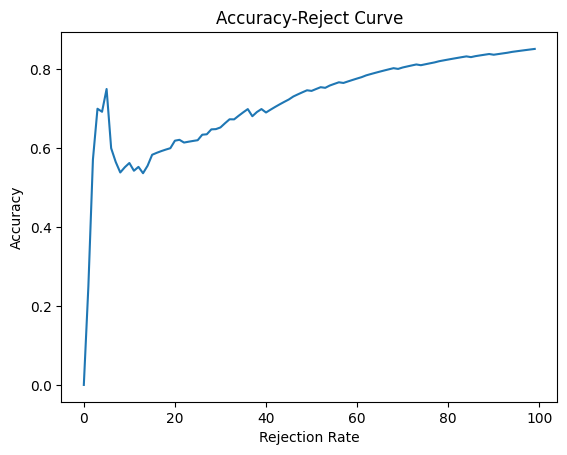

In [141]:
# Assuming predictions are the class with the highest mean probability
predicted_classes = mc_mean.argmax(axis=1)
predicted_class_uncertainty = mc_uncertainty[np.arange(len(mc_uncertainty)), predicted_classes]

# Assuming test_labels is a list or array of the true labels
test_labels = targets
accuracies = []
rejection_rates = np.linspace(0.999, 0.001, 100)

for rejection_rate in rejection_rates:
    num_reject = int(len(predicted_class_uncertainty) * rejection_rate)
    indices_to_keep = np.argsort(predicted_class_uncertainty)[num_reject:]
    
    selected_labels = test_labels[indices_to_keep]
    selected_predictions = predicted_classes[indices_to_keep]
    
    accuracy = accuracy_score(selected_labels, selected_predictions)

    accuracies.append(accuracy)

# Plotting the accuracy-reject curve
plt.plot(accuracies)
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve')
plt.show()


In [142]:
from sklearn.utils import resample

# Number of bootstrap samples
n_bootstraps = 1000

# Initialize list to store upper and lower bounds of uncertainty
lower_bounds = []
upper_bounds = []

for rejection_rate in rejection_rates:
    num_reject = int(len(predicted_class_uncertainty) * rejection_rate)
    indices_to_keep = np.argsort(predicted_class_uncertainty)[num_reject:]
    
    bootstrap_accuracies = []
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        boot_indices = resample(indices_to_keep)
        boot_labels = targets[boot_indices]
        boot_predictions = predicted_classes[boot_indices]

        # Calculate bootstrap accuracy
        boot_accuracy = accuracy_score(boot_labels, boot_predictions)
        bootstrap_accuracies.append(boot_accuracy)

    # Calculate the lower and upper bound of the uncertainty
    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)

    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)


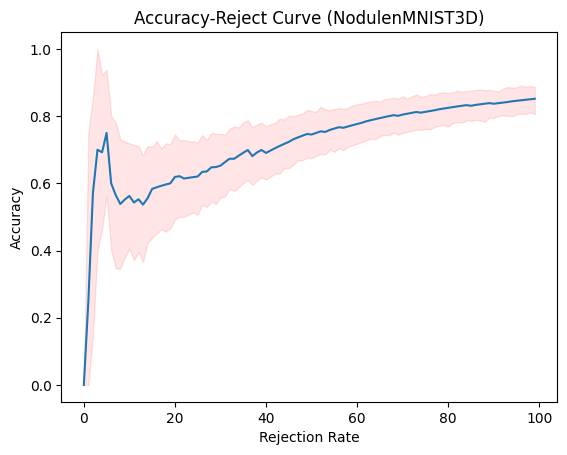

In [143]:
# draw the uncertainty interval
plt.plot(accuracies,label='Accuracy')
plt.fill_between(range(len(lower_bounds)), lower_bounds, upper_bounds, color='red', alpha=0.1, label='Uncertainty Region')
plt.xlabel('Rejection Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy-Reject Curve (NodulenMNIST3D)')
plt.show()
